In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

Importing plotly failed. Interactive plots will not work.


In [6]:
df = pd.read_pickle('../sample_data/tw_0050_close_price_daily.pickle')
train = df.rename(columns = {'Date':'ds', 'Close':'y'})
train.head()

,ds,y
0,2008-01-02,60.009998
1,2008-01-03,58.889999
2,2008-01-04,59.009998
3,2008-01-07,56.389999
4,2008-01-08,56.980000


In [4]:
Lehman = pd.DataFrame({
  'holiday': 'Lehman_bankrupt',
  'ds': pd.to_datetime(['2008-09-15']),
  'lower_window': 0,
  'upper_window': 0,
})
mother_day = pd.DataFrame({
  'holiday': 'mother',
  'ds': pd.to_datetime(['2020-5-10', '2021-05-09', '2022-05-08']),
  'lower_window': 0,
  'upper_window': 0,
})
#holidays = pd.concat((Lehman, mother_day))
holidays = Lehman

In [8]:
changepoints = None
#changepoints = ['2011-08-02','2015-08-03','2018-10-01','2020-03-09']

In [215]:
m = Prophet(
    growth='linear',
    changepoints = None,
    n_changepoints = 10,
    changepoint_range = 0.90,
    yearly_seasonality = 'auto', #[True, False, 'auto']
    weekly_seasonality = False, #[True, False, 'auto']
    daily_seasonality = 'auto', #[True, False, 'auto']
    holidays = None,
    seasonality_mode = 'multiplicative',#['additive','multiplicative']
    seasonality_prior_scale = 10.0,
    holidays_prior_scale=10.0,
    changepoint_prior_scale = 0.01,
    mcmc_samples=0,
    interval_width=0.8,
    uncertainty_samples=1000,
    stan_backend=None)

In [216]:
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


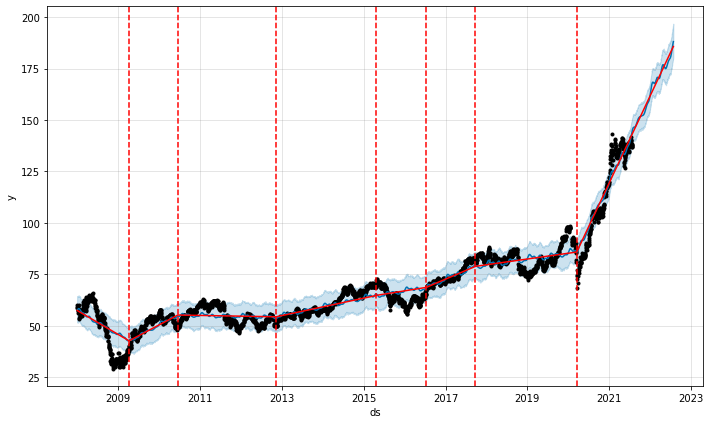

In [219]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

If you want to see the forecast components, you can use the `Prophet.plot_components` method.  By default you'll see the trend, yearly seasonality, and weekly seasonality of the time series.  If you include holidays, you'll see those here, too.

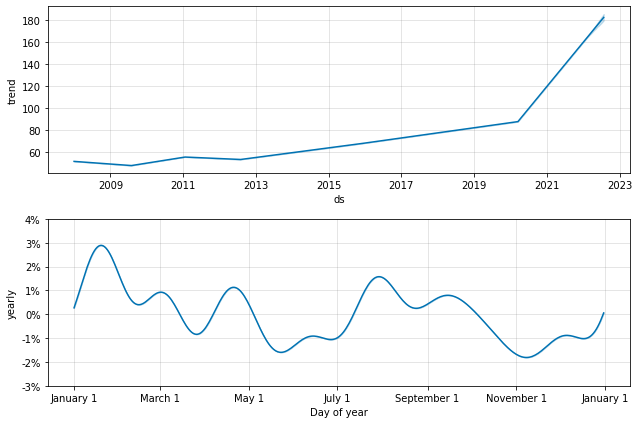

In [213]:
fig2 = m.plot_components(forecast)

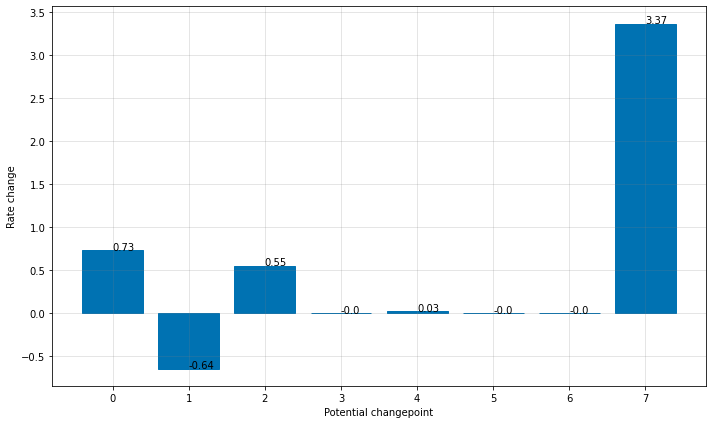

In [214]:
deltas = m.params['delta'].mean(0)
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas, facecolor='#0072B2', edgecolor='#0072B2')
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_ylabel('Rate change')
ax.set_xlabel('Potential changepoint')
for index, value in enumerate(deltas):
    ax.text(index, value, str(round(value,2)))
fig.tight_layout()

In [149]:
from prophet.diagnostics import cross_validation
cutoffs = pd.to_datetime(['2013-12-20','2016-03-20'])
df_cv = cross_validation(m, cutoffs=cutoffs, horizon= '30 days')
# cutoff = df_cv['cutoff'].unique()[0]
# df_cv = df_cv[df_cv['cutoff'].values == cutoff]

  0%|          | 0/2 [00:00<?, ?it/s]

Text(0.5, 0, 'ds')

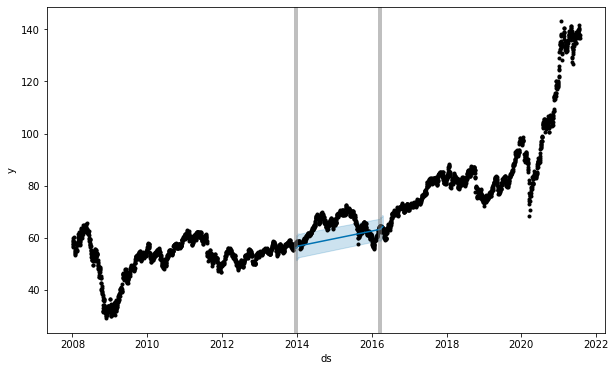

In [150]:
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
for cutoff in df_cv['cutoff'].unique():
    ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')
# ax.text(x=pd.to_datetime('2010-01-01'),y=12, s='Initial', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8)
# ax.text(x=pd.to_datetime('2012-08-01'),y=12, s='Cutoff', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8)
# ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
#            alpha=0.5, ls='--')
# ax.text(x=pd.to_datetime('2013-01-01'),y=6, s='Horizon', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8);

In [151]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.814358,1.346981,1.304955,0.021306,0.017516,0.021558,1.0
1,4 days,1.968705,1.403105,1.355273,0.022569,0.029234,0.022853,1.0
2,5 days,1.747653,1.321988,1.249224,0.020897,0.015271,0.021152,1.0
3,6 days,2.039356,1.428060,1.360152,0.023096,0.028811,0.023400,1.0
4,7 days,3.030239,1.740758,1.676179,0.028671,0.028850,0.029125,1.0


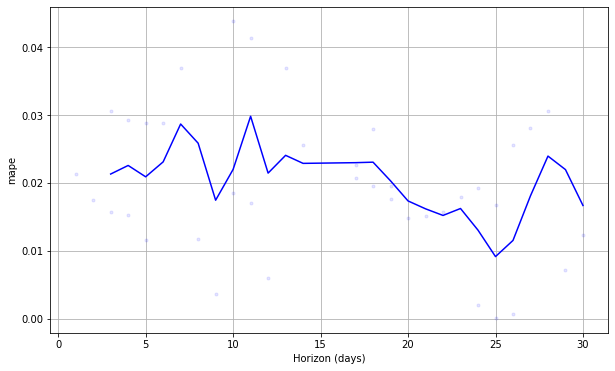

In [152]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [153]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [155]:
mean_absolute_error(df_cv.y[0:4],df_cv.yhat[0:4])

1.6994707617591658

In [ ]:
import itertools
import numpy as np
import pandas as pd

# param_grid = {  
#     'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
#     'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     m = Prophet(**params).fit(df)  # Fit model with given params
#     df_cv = cross_validation(m, '30 days', initial='365 days', period='90 days')
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)